In [24]:
# --- SET ENVIRONMENT VARIABLE TO FIX SCIPY/SKLEARN CONFLICT ---
import os
os.environ['SCIPY_ARRAY_API'] = '1'
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [14]:
# Machine learning tool-kits

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ( f1_score, average_precision_score, confusion_matrix, classification_report)


In [21]:
# Ensemble Model and Imbalance Handling 
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [18]:
# 2. DATA LOADING AND PREPARATION 

print("--- Loading and preparing E-commerce data ---")
fraud_df = pd.read_csv('../data/01_raw/Fraud_Data.csv')
fraud_df.drop_duplicates(inplace=True)
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()
# Create the variable that was causing the NameError
fraud_df_model = fraud_df.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)

print("\n--- Loading and preparing Credit Card data ---")
credit_df = pd.read_csv('../data/01_raw/creditcard.csv')
credit_df.drop_duplicates(inplace=True)
print("Data loading and preparation complete.")


--- Loading and preparing E-commerce data ---

--- Loading and preparing Credit Card data ---
Data loading and preparation complete.


In [ ]:
def build_and_evaluate_model(df, target_column, model, model_name):
    """
    Builds a full preprocessing and modeling pipeline, trains it,
    evaluates it, and saves the confusion matrix plot.
    """
    print(f"\n" + "="*50)
    print(f"--- Processing Model: {model_name} ---")
    print("="*50)
    
    # Steps 1-4: Split and Preprocess 
    x = df.drop(target_column, axis=1)
    y = df[target_column]

    x_train, x_test, y_train, y_test = train_test_split(
        x,y, test_size=0.2, random_state=42, stratify=y
    )

    numeric_feature = x.select_dtypes(include=np.number).columns.tolist()
    categorical_feature = x.select_dtypes(exclude=np.number).columns.tolist()

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature),
            ('cat', categorical_transformer, categorical_feature)
        ]
    )
    
    #  Step 5: Create and Train Pipeline (No changes here) 
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    pipeline.fit(x_train, y_train)

    # Step 6-7: Predict and Evaluate
    y_pred = pipeline.predict(x_test)
    y_proba = pipeline.predict_proba(x_test)[:,1]

    print("\n--- Evaluation on Test Set ---")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-PR (Average Precision): {average_precision_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

    # Step 8: Plot and SAVE the Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6)) # Create a new figure for the plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.ylabel('Actual (True Class)', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)


    # 1. Define the directory path
    output_dir = '../reports/figures'
    # 2. Create the directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # 3. Create a descriptive filename
    plot_filename = f'{model_name.replace(" ", "_").lower()}_confusion_matrix.png'
    full_path = os.path.join(output_dir, plot_filename)
    # 4. Save the figure with high resolution
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix plot saved to: {full_path}")

    
    plt.show() # Display the plot in the notebook

    # --- Step 9: Save the Model (No changes here) ---
    model_filename = f'../models/{model_name.replace(" ", "_").lower()}.joblib'
    os.makedirs(os.path.dirname(model_filename), exist_ok=True)
    joblib.dump(pipeline, model_filename)
    print(f"Model saved to {model_filename}")

    return pipeline


--- Processing Model: E-commerce Logistic Regression ---

--- Evaluation on Test Set ---
F1 Score: 0.2686
AUC-PR (Average Precision): 0.4541

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.95      0.64      0.77     27393
       Fraud       0.17      0.69      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223


Confusion Matrix:
Confusion matrix plot saved to: ../reports/figures\e-commerce_logistic_regression_confusion_matrix.png


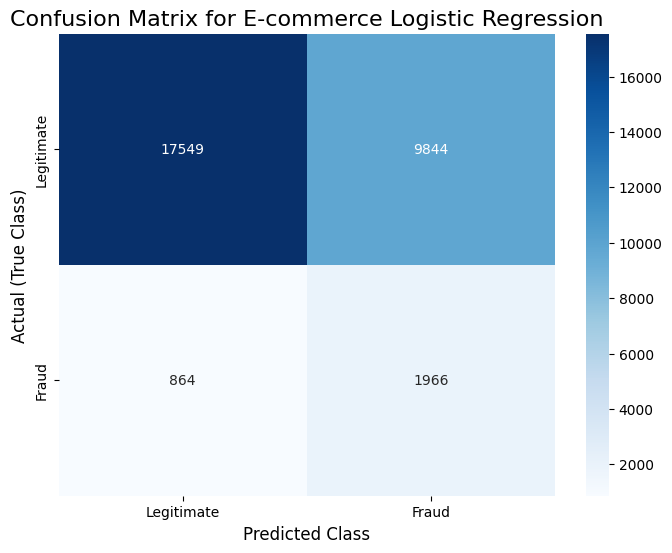

Model saved to ../models/e-commerce_logistic_regression.joblib

--- Processing Model: E-commerce LightGBM ---
[LightGBM] [Info] Number of positive: 109568, number of negative: 109568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 219136, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Evaluation on Test Set ---
F1 Score: 0.6900
AUC-PR (Average Precision): 0.6203

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.95      1.00      0.98     27393
       Fraud       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223


Confusion Matrix:
Confusion matrix plot saved to: ../reports/figures\e-commerce_lightgbm_confusion_matrix.png


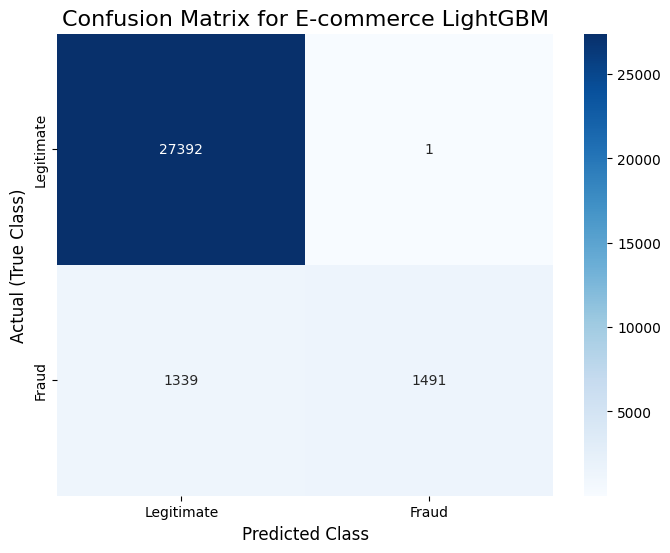

Model saved to ../models/e-commerce_lightgbm.joblib


In [29]:
# Step 3 run models on E-commerce Data

lr_model_ecom = LogisticRegression(random_state=42, solver='liblinear') 
lgbm_model_ecom = lgb.LGBMClassifier(random_state=42)

lr_pipeline_ecom = build_and_evaluate_model(
    df=fraud_df_model,
    target_column='class',
    model= lr_model_ecom,
    model_name="E-commerce Logistic Regression"
) 
# call our function for the LightGBM model

lgbm_model_ecom = build_and_evaluate_model(
    df=fraud_df_model,
    target_column='class',
    model=lgbm_model_ecom,
    model_name="E-commerce LightGBM"

)


--- Processing Model: Credit Card Logistic Regression ---

--- Evaluation on Test Set ---
F1 Score: 0.0995
AUC-PR (Average Precision): 0.6734

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99     56651
       Fraud       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746


Confusion Matrix:
Confusion matrix plot saved to: ../reports/figures\credit_card_logistic_regression_confusion_matrix.png


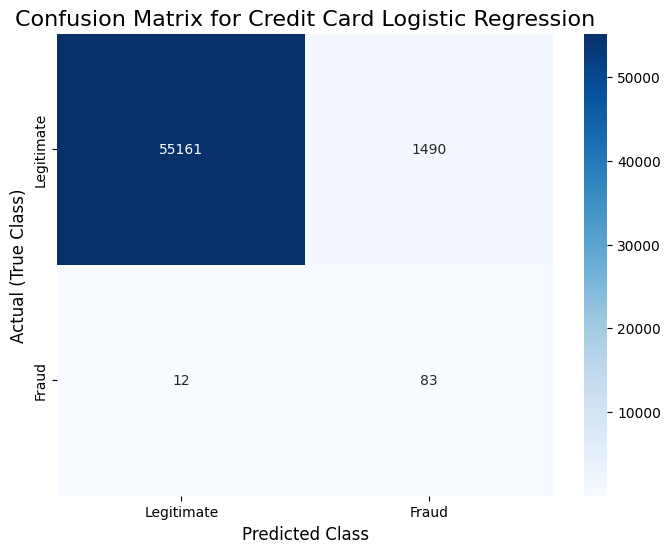

Model saved to ../models/credit_card_logistic_regression.joblib

--- Processing Model: Credit Card LightGBM ---
[LightGBM] [Info] Number of positive: 226602, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 453204, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Evaluation on Test Set ---
F1 Score: 0.6638
AUC-PR (Average Precision): 0.7477

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
       Fraud       0.56      0.82      0.66        95

    accuracy                           1.00     56746
   macro avg       0.78      0.91      0.83     56746
weighted avg       1.00      1.00      1.00     56746


Confusion Matrix:
Confusion matrix plot saved to: ../reports/figures\credit_card_lightgbm_confusion_matrix.png


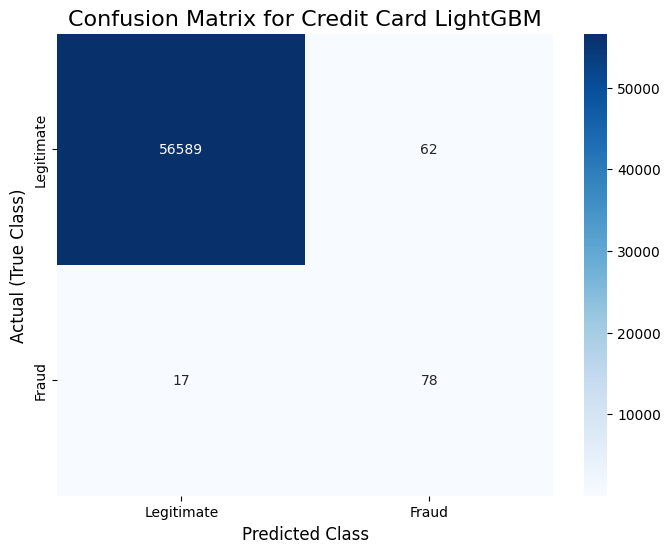

Model saved to ../models/credit_card_lightgbm.joblib

All models have been trained and evaluated.


In [30]:
# Step 4 running on credit card csv

lr_model_credit = LogisticRegression(random_state=42, solver='liblinear')
lgbm_model_credit = lgb.LGBMClassifier(random_state=42)

# 2. Call our function for the Logistic Regression model
#    Note the different 'df' and 'target_column' arguments
lr_pipeline_credit = build_and_evaluate_model(
    df=credit_df,
    target_column='Class',  # The target column in this dataset is 'Class' (with a capital C)
    model=lr_model_credit,
    model_name="Credit Card Logistic Regression"
)

# 3. Call our function for the LightGBM model
lgbm_pipeline_credit = build_and_evaluate_model(
    df=credit_df,
    target_column='Class',
    model=lgbm_model_credit,
    model_name="Credit Card LightGBM"
)

print("\nAll models have been trained and evaluated.")